In [576]:
## Autograd
import autograd.numpy as np
from autograd.numpy.random import seed, randn, rand
from autograd.numpy import exp, hstack, log
from autograd import grad, jacobian
from autograd.numpy.linalg import norm
from autograd.scipy.stats import norm as ag_norm
from autograd.extend import primitive, defvjp
from autograd.numpy.numpy_vjps import unbroadcast_f

# Standard Python Imports
from scipy.stats import norm as ndist
from scipy.stats import uniform as udist
from numpy import zeros, eye, vstack, sqrt, mean
from scipy.stats import multivariate_normal as MVN
from numpy.random import uniform
from scipy.optimize import fsolve
from statsmodels.tsa.stattools import acf

# Custom functions
from tangential_hug_functions import HugTangentialStepEJSD_Deterministic, Hop_Deterministic, HugStepEJSD_Deterministic, HugRotatedStepEJSD_AR_Deterministic, HugRotatedStepEJSD_Deterministic
from utils import ESS_univariate, ESS, n_unique

import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

In [858]:
m = 2

In [859]:
def f(thetau):
    """Deterministic function for distance manifold. f:R^5 -> R """
    a_param, b_param, k_param, *z = thetau  # Latents are standard normal variables
    z = np.array(z)
    out = a_param + b_param*(1 + 0.8 * (1 - exp(-g_param * z)) / (1+exp(-g_param * z))) * ((1 + z**2)**k_param) * z
    return norm(out - y_star)

In [860]:
def data_generator(theta, N=m):
    """Generates initial observed data y_star."""
    z = randn(N)         # Get N samples from N(0, 1) for G&K simulation.
    a_param, b_param, k_param = theta   # Grab parameters
    return a_param + b_param*(1 + 0.8 * (1 - exp(-g_param * z)) / (1+exp(-g_param * z))) * ((1 + z**2)**k_param) * z

In [861]:
theta0 = np.array([3.0, 1.0, 0.5])
g_param = 2.0
y_star = data_generator(theta0, N=m)

In [862]:
grad_function = grad(f)

In [863]:
d = 3 + m

In [864]:
def logprior(thetau):
    """Log prior distribution."""
    with np.errstate(divide='ignore'):
        return log((abs(thetau[:3]) <= 10).all().astype('float64')) + ndist.logpdf(thetau[3:]).sum()
    
def log_uniform_kernel(xi, epsilon):
    """Log density of uniform kernel. """
    with np.errstate(divide='ignore'):
        return log((f(xi) <= epsilon).astype('float64'))
    
def log_abc_posterior(xi):
    """Log density of ABC posterior. Product of (param-latent) prior and uniform kernel."""
    return logprior(xi) + log_uniform_kernel(xi, epsilon)

In [865]:
##### rhug
def experiment_rhug(x00, T, N, alphas, nlags):
    """Runs Hug+Hop and RotatedHUG+HOP using the same velocities and the same random seeds.
    We also try to limit the noise in the HOP kernel by sampling the u variables beforehand.
    I run RotatedHUG for all values of alpha with the randomness fixed. 
    This is 1 run, for 1 epsilon. It does 1 HUG+HOP and then THUG+HOP for all alphas.
    T1: T for HUG
    T2: T for RotatedHUG
    """
    ### COMMON VARIABLES
    v = q.rvs(N)
    log_uniforms1 = log(rand(N))     # Log uniforms for the HUG kernels
    log_uniforms2 = log(rand(N))     # Log uniforms for the HOP kernel
    u = MVN(zeros(d), eye(d)).rvs(N) # Original velocities for HOP kernel
    ### STORAGE (HUG + HOP)
    hh = x00              # Initial sample
    ahh1 = 0.0            # Acceptance probability for HUG kernel
    ahh2 = 0.0            # Acceptance probability for HOP kernel (when used with HUG)
    ehh = 0.0             # EJSD
    eghh = 0.0            # EJSD in Gradient direction
    ethh = 0.0            # EJSD in Tangent direction
    ### STORAGE (RotatedHUG + HOP) I MUST STORE FOR ALL ALPHAS
    arh1 = zeros(n_alphas)
    arh2 = zeros(n_alphas)
    erh  = zeros(n_alphas)
    egrh = zeros(n_alphas)
    etrh = zeros(n_alphas)
    ### ADDITIONAL STORAGE FOR RotatedHUG
    rh_esst = zeros(n_alphas)
    rh_essu = zeros(n_alphas)
    rh_essj = zeros(n_alphas)
    rh_uniq = zeros(n_alphas)
    rh_act  = zeros((n_alphas, nlags))
    rh_acu  = zeros((n_alphas, nlags))
    ### HUG + HOP
    x = x00
    for i in range(N):
        y, a1, e, eg, et = HugStepEJSD_Deterministic(x, v[i], log_uniforms1[i], T, B, q, log_abc_posterior, grad_function)
        x, a2 = Hop_Deterministic(y, u[i], log_uniforms2[i], lam, kappa, log_abc_posterior, grad_function)
        hh = vstack((hh, y, x))
        ahh1 += a1 * 100 / N
        ahh2 += a2 * 100 / N
        ehh += e / N
        eghh += eg / N 
        ethh += et / N 
    # COMPUTE ESS AND OTHER METRICS FOR HUG
    hh = hh[1:]
    hh_esst = ESS_univariate(hh[::2, 0])     # ESS for theta
    hh_essu = ESS_univariate(hh[::2, 1])     # ESS for u
    hh_essj = ESS(hh[::2])                   # ESS joint
    hh_uniq = n_unique(hh)                             # Number of unique samples
    hh_act  = acf(hh[::2, 0], adjusted=True, nlags=nlags, fft=True)[1:]  # Autocorrelation for theta (remove the first 1.0)
    hh_acu  = acf(hh[::2, 1], adjusted=True, nlags=nlags, fft=True)[1:]  # Autocorrelation for u
    ### RotatedHUG + HOP
    for k, alpha in enumerate(alphas):
        x = x00
        rh = x00      # RESTART THE SAMPLES FROM SCRATCH
        for i in range(N):
            y, a1, e, eg, et = HugRotatedStepEJSD_Deterministic(x, v[i], log_uniforms1[i], T, B, alpha, q, log_abc_posterior, grad_function)
            x, a2 = Hop_Deterministic(y, u[i], log_uniforms2[i], lam, kappa, log_abc_posterior, grad_function)
            rh = vstack((rh, y, x))
            arh1[k] += a1 * 100 / N
            arh2[k] += a2 * 100 / N
            erh[k]  += e / N
            egrh[k] += eg / N 
            etrh[k] += et / N 
        ### COMPUTE ESS AND OTHER METRISC FOR RotatedHUG
        rh = rh[1:]
        rh_esst[k] = ESS_univariate(rh[::2, 0])     # ESS for theta
        rh_essu[k] = ESS_univariate(rh[::2, 1])     # ESS for u
        rh_essj[k] = ESS(rh[::2])                   # ESS joint
        rh_uniq[k] = n_unique(rh)                             # Number of unique samples
        rh_act[k] = acf(rh[::2, 0], adjusted=True, nlags=nlags, fft=True)[1:]  # Autocorrelation for theta
        rh_acu[k] = acf(rh[::2, 1], adjusted=True, nlags=nlags, fft=True)[1:]  # Autocorrelation for u
    # RETURN EVERYTHING
    out = {
        'HH': {
            'A1': ahh1,
            'A2': ahh2,
            'E': ehh,
            'EG': eghh, 
            'ET': ethh,
            'ESS_T': hh_esst,
            'ESS_U': hh_essu,
            'ESS_J': hh_essj,
            'UNIQUE': hh_uniq,
            'AC_T': hh_act,
            'AC_U': hh_acu,
            'SAMPLES': hh
        },
        'RH': {
            'A1': arh1,
            'A2': arh2,
            'E': erh,
            'EG': egrh, 
            'ET': etrh, 
            'ESS_T': rh_esst,
            'ESS_U': rh_essu,
            'ESS_J': rh_essj,
            'UNIQUE': rh_uniq,
            'AC_T': rh_act,
            'AC_U': rh_acu,
            'SAMPLES': rh
        }
    }
    return out

In [866]:
#### thug
def experiment_thug(x00, T, N, alphas, nlags):
    """Runs Hug+Hop and THUG+HOP using the same velocities and the same random seeds.
    We also try to limit the noise in the HOP kernel by sampling the u variables beforehand.
    I run THUG for all values of alpha with the randomness fixed. 
    This is 1 run, for 1 epsilon. It does 1 HUG+HOP and then THUG+HOP for all alphas.
    T1: T for HUG
    T2: T for THUG
    """
    ### COMMON VARIABLES
    v = q.rvs(N)
    log_uniforms1 = log(rand(N))     # Log uniforms for the HUG kernels
    log_uniforms2 = log(rand(N))     # Log uniforms for the HOP kernel
    u = MVN(zeros(d), eye(d)).rvs(N) # Original velocities for HOP kernel
    ### STORAGE (HUG + HOP)
    hh = x00              # Initial sample
    ahh1 = 0.0       # Acceptance probability for HUG kernel
    ahh2 = 0.0       # Acceptance probability for HOP kernel (when used with HUG)
    ehh = 0.0             # EJSD
    eghh = 0.0            # EJSD in Gradient direction
    ethh = 0.0            # EJSD in Tangent direction
    ### STORAGE (THUG + HOP) I MUST STORE FOR ALL ALPHAS
    ath1 = zeros(n_alphas)
    ath2 = zeros(n_alphas)
    eth  = zeros(n_alphas)
    egth = zeros(n_alphas)
    etth = zeros(n_alphas)
    ### ADDITIONAL STORAGE FOR THUG
    th_esst = zeros(n_alphas)
    th_essu = zeros(n_alphas)
    th_essj = zeros(n_alphas)
    th_uniq = zeros(n_alphas)
    th_act  = zeros((n_alphas, nlags))
    th_acu  = zeros((n_alphas, nlags))
    ### HUG + HOP
    x = x00
    for i in range(N):
        y, a1, e, eg, et = HugStepEJSD_Deterministic(x, v[i], log_uniforms1[i], T, B, q, log_abc_posterior, grad_function)
        x, a2 = Hop_Deterministic(y, u[i], log_uniforms2[i], lam, kappa, log_abc_posterior, grad_function)
        hh = vstack((hh, y, x))
        ahh1 += a1 * 100 / N
        ahh2 += a2 * 100 / N
        ehh += e / N
        eghh += eg / N 
        ethh += et / N 
    # COMPUTE ESS AND OTHER METRICS FOR HUG
    hh = hh[1:]
    hh_esst = ESS_univariate(hh[::2, 0])     # ESS for theta
    hh_essu = ESS_univariate(hh[::2, 1])     # ESS for u
    hh_essj = ESS(hh[::2])                   # ESS joint
    hh_uniq = n_unique(hh)                             # Number of unique samples
    hh_act  = acf(hh[::2, 0], adjusted=True, nlags=nlags, fft=True)[1:]  # Autocorrelation for theta (remove the first 1.0)
    hh_acu  = acf(hh[::2, 1], adjusted=True, nlags=nlags, fft=True)[1:]  # Autocorrelation for u
    ### THUG + HOP
    for k, alpha in enumerate(alphas):
        x = x00
        th = x00      # RESTART THE SAMPLES FROM SCRATCH
        for i in range(N):
            y, a1, e, eg, et = HugTangentialStepEJSD_Deterministic(x, v[i], log_uniforms1[i], T, B, alpha, q, log_abc_posterior, grad_function)
            x, a2 = Hop_Deterministic(y, u[i], log_uniforms2[i], lam, kappa, log_abc_posterior, grad_function)
            th = vstack((th, y, x))
            ath1[k] += a1 * 100 / N
            ath2[k] += a2 * 100 / N
            eth[k]  += e / N
            egth[k] += eg / N 
            etth[k] += et / N 
        ### COMPUTE ESS AND OTHER METRISC FOR THUG
        th = th[1:]
        th_esst[k] = ESS_univariate(th[::2, 0])     # ESS for theta
        th_essu[k] = ESS_univariate(th[::2, 1])     # ESS for u
        th_essj[k] = ESS(th[::2])                   # ESS joint
        th_uniq[k] = n_unique(th)                             # Number of unique samples
        th_act[k] = acf(th[::2, 0], adjusted=True, nlags=nlags, fft=True)[1:]  # Autocorrelation for theta
        th_acu[k] = acf(th[::2, 1], adjusted=True, nlags=nlags, fft=True)[1:]  # Autocorrelation for u
    # RETURN EVERYTHING
    out = {
        'HH': {
            'A1': ahh1,
            'A2': ahh2,
            'E': ehh,
            'EG': eghh, 
            'ET': ethh,
            'ESS_T': hh_esst,
            'ESS_U': hh_essu,
            'ESS_J': hh_essj,
            'UNIQUE': hh_uniq,
            'AC_T': hh_act,
            'AC_U': hh_acu,
            'SAMPLES': hh
        },
        'TH': {
            'A1': ath1,
            'A2': ath2,
            'E': eth,
            'EG': egth, 
            'ET': etth, 
            'ESS_T': th_esst,
            'ESS_U': th_essu,
            'ESS_J': th_essj,
            'UNIQUE': th_uniq,
            'AC_T': th_act,
            'AC_U': th_acu,
            'SAMPLES': th
        }
    }
    return out

In [867]:
q = MVN(zeros(d), eye(d))

In [1412]:
alphas = [0.99]
n_alphas = len(alphas)
epsilon = 0.000001
T1 = T2 = 0.003      # 0.3
B = 5
N = 30000
nlags = 2
lam = epsilon / 30
kappa = 0.001

In [1413]:
# Start with a guess
guess = hstack((np.array([1.0, 1.0, 1.0]), zeros(m)))

# Find point on manifold using optimization
func = lambda xi: np.r_[f(xi), zeros(d-1)]  # Append 0, 0 to make fsolve work.
xi0 = fsolve(func, guess)
print(xi0)

[ 2.59788949  1.05353569  1.00476645 -0.46024686  0.24281118]


In [1414]:
# Start with a guess
guess = hstack((np.array([3.0, 3.0, 3.0]), zeros(m)))

# Find point on manifold using optimization
func = lambda xi: np.r_[f(xi), zeros(d-1)]  # Append 0, 0 to make fsolve work.
xi0 = fsolve(func, guess)
print(xi0)

[ 2.38096376  3.02253956  3.00081191 -0.05795841  0.14935078]


In [1415]:
out = experiment_thug(xi0, T1, N, alphas, 20)
alg = 'TH'
alg_name = 'thug'

In [1416]:
out['HH']['A1'], out['HH']['A2'], out['HH']['E'], out['HH']['ESS_J'] / N

(0.06333333333333334,
 2.406666666666695,
 1.8197467487740908e-08,
 0.005883740349569586)

In [1417]:
out[alg]['A1'], out[alg]['A2'], out[alg]['E'], out[alg]['ESS_J'] / N

(array([0.18666667]),
 array([2.45333333]),
 array([4.71520613e-08]),
 array([0.00605555]))

In [1418]:
out[alg]['A1'][0] / out['HH']['A1']

2.947368421052628

##### $m = 2$, $\epsilon = 0.00001$, $T=0.003$, $N=2000$ gives 6 AP for HUG and 7.5 AP for THUG with $\alpha=0.85$. Ratio 1.35, 0.8, 0.5

$\alpha=0.8$ I get 0.78, 1.42, 0.8, 0.9, 1.05

$\alpha = 0.75$  1.05, 0.91

$\alpha=0.65$ $N=2000$ 1.3, 1.16, 1.16, 1.45, 1.28

$\alpha=0.65$ but with $N=10000$: 0.6, 0.95, 0.48, 0.6 mean = 0.65

$\alpha=0.5$ but with $N=10000$: 1.07, 1.98, 1.33, 1.65, 1.16 mean = 1.438

$\alpha=0.5$ but with $N=30000$: 0.78, 1.28, 0.73, 3.5, 1.92, 1.82, 1.07 mean = 1.58 

$\alpha=0.7$ but with $N=30000$: 1.19, 0.59, 0.95, 0.5 mean=0.8

$\epsilon = 0.000001$ with $N=30000$ and $\alpha = 0.7$: 0.68, 0.8, 0.29, 1.34 mean=0.77

$\epsilon = 0.000001$ with $N=30000$ and $\alpha = 0.9$: 1.30, 3.0, 1.56, 1.04, 4.7 mean=2.32

$\epsilon = 0.000001$ with $N=30000$ and $\alpha = 0.95$: 1.5, 0.54, 0.41, 1.19, 2.26 mean=1.18

$\epsilon = 0.000001$ with $N=30000$ and $\alpha = 0.99$: 2.02, 2.48, 2.33, 2.18, 2.94 mean=2.38

$\epsilon = 0.000001$ with $N=30000$ and $\alpha = 0.999$: 1.74, 1.92, 1.78, 1.28, 1.43 mean=1.63

In [1419]:
!say done

In [1420]:
(2.02 + 2.48 + 2.33 + 2.18 + 2.94) / 5

2.3899999999999997

In [1266]:
TS = [10, 1, 0.1]
alphas = [0.9, 0.99]
epsilons = [0.1, 0.01, 0.001, 0.0001]
n_runs = 5
runs = list(range(n_runs))

In [1267]:
from itertools import product

In [1271]:
list(product(*[TS, epsilons]))

[(10, 0.1),
 (10, 0.01),
 (10, 0.001),
 (10, 0.0001),
 (1, 0.1),
 (1, 0.01),
 (1, 0.001),
 (1, 0.0001),
 (0.1, 0.1),
 (0.1, 0.01),
 (0.1, 0.001),
 (0.1, 0.0001)]

In [1275]:
list(product(*[TS, epsilons]))[0]

(10, 0.1)

In [1336]:
find_initial_points(3)

array([[ 2.58351621,  2.56652777,  0.97424638, -0.16185032,  0.11836733],
       [ 2.46012061,  2.76341858,  1.76965839, -0.09556525,  0.14413256],
       [ 2.54521601,  1.10902825,  2.38040447, -0.31684965,  0.24643879]])

In [1332]:
uniform(0.0, 3.0, size=3)

array([1.37110743, 0.60423699, 2.92966846])

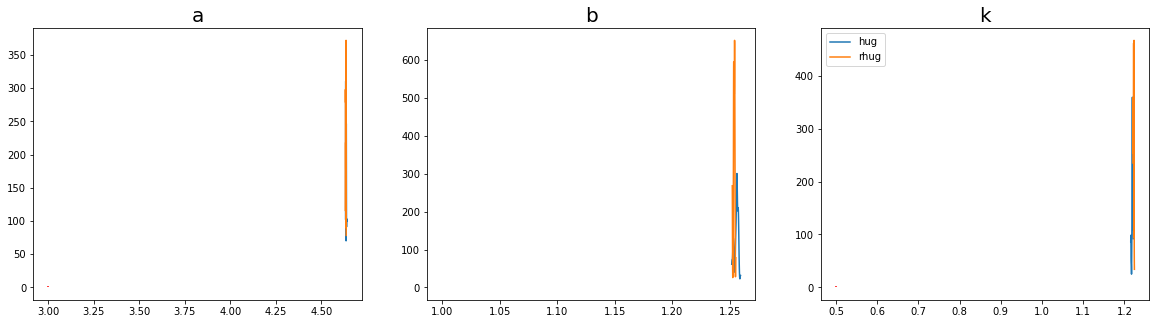

In [732]:
# HUG KDES
akde_hug = gaussian_kde(out['HH']['SAMPLES'][:, 0])
bkde_hug = gaussian_kde(out['HH']['SAMPLES'][:, 1])
kkde_hug = gaussian_kde(out['HH']['SAMPLES'][:, 2])
# HUG linspaces
xa_hug = np.linspace(np.min(out['HH']['SAMPLES'][:, 0]), np.max(out['HH']['SAMPLES'][:, 0]))
xb_hug = np.linspace(np.min(out['HH']['SAMPLES'][:, 1]), np.max(out['HH']['SAMPLES'][:, 1]))
xk_hug = np.linspace(np.min(out['HH']['SAMPLES'][:, 2]), np.max(out['HH']['SAMPLES'][:, 2]))
# THUG KDES
akde_thug = gaussian_kde(out[alg]['SAMPLES'][:, 0])
bkde_thug = gaussian_kde(out[alg]['SAMPLES'][:, 1])
kkde_thug = gaussian_kde(out[alg]['SAMPLES'][:, 2])
# THUG linspaces
xa_thug = np.linspace(np.min(out[alg]['SAMPLES'][:, 0]), np.max(out[alg]['SAMPLES'][:, 0]))
xb_thug = np.linspace(np.min(out[alg]['SAMPLES'][:, 1]), np.max(out[alg]['SAMPLES'][:, 1]))
xk_thug = np.linspace(np.min(out[alg]['SAMPLES'][:, 2]), np.max(out[alg]['SAMPLES'][:, 2]))


fig, ax = plt.subplots(ncols=3, figsize=(20, 5))
# First parameter (a)
ax[0].plot(xa_hug, akde_hug(xa_hug), label='hug')
ax[0].plot(xa_thug, akde_thug(xa_thug), label=alg_name)
ax[0].vlines(theta0[0], ymin=0, ymax=2, colors='red')
ax[0].set_title("a", fontsize=20)
# Second parameter (b)
ax[1].plot(xb_hug, bkde_hug(xb_hug), label='hug')
ax[1].plot(xb_thug, bkde_thug(xb_thug), label=alg_name)
ax[1].vlines(theta0[1], ymin=0, ymax=2, colors='red')
ax[1].set_title("b", fontsize=20)
# Third parameter (k)
ax[2].plot(xk_hug, kkde_hug(xk_hug), label='hug')
ax[2].plot(xk_thug, kkde_thug(xk_thug), label=alg_name)
ax[2].vlines(theta0[2], ymin=0, ymax=2, colors='red')
ax[2].set_title("k", fontsize=20)
plt.legend()
plt.show()

In [668]:
!say EXPERIMENT FINISHED

At the very least, using THUG I should be able to get a better acceptance probability. If not, perhaps there is a bug in the problem formulation? Should change to THUG experiment and see if there is an improvement there. If there is no improvement in AP and if there is no bug, what could be causing this? Perhaps the manifold has very high curvature and so following the tangent is not desirable?

In [1565]:
Sigma = np.array([[5.0, 2.0], [3.0, 1.0]])

def move(xv):
    n = int(len(xv) / 2)
    x, v = xv[:n], xv[n:]
    return np.concatenate((x + 5.0 * v, v))

def reflect(xv):
    n = int(len(xv) / 2)
    x, v = xv[:n], xv[n:]
    ghat = - Sigma @ x
    ghat = ghat / np.linalg.norm(ghat)
    return np.concatenate((x, v - 2*ghat*(ghat@v)))

In [1566]:
x = np.array([1.0, 2.0])
v = np.array([3.0, 4.0])
xv = np.concatenate((x, v))

In [1567]:
jacobian(move)(xv), np.linalg.det(jacobian(move)(xv))

(array([[1., 0., 5., 0.],
        [0., 1., 0., 5.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]),
 1.0)

In [1568]:
jacobian(reflect)(xv), np.linalg.det(jacobian(reflect)(xv))

(array([[ 1.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  1.        ,  0.        ,  0.        ],
        [ 0.01637593, -0.00818797, -0.52830189, -0.8490566 ],
        [-0.18796725,  0.09398362, -0.8490566 ,  0.52830189]]),
 -1.0)

In [1569]:
g = - Sigma @ x

In [1570]:
ghat = g / np.linalg.norm(g)

In [1590]:
JJ = (np.eye(2) - np.outer(ghat, ghat)) @ (-Sigma) / np.linalg.norm(g)

In [1645]:
# amount left
(jacobian(reflect)(xv)[2:, :2] + 2*JJ*(ghat @ v)) / (-2)

array([[ 0.03364187, -0.01682093],
       [ 0.01868993, -0.00934496]])

In [1651]:
np.outer(ghat, JJ @ v)

array([[-0.00800997,  0.01441794],
       [-0.00444998,  0.00800997]])

In [1665]:
JJ @ v

array([ 0.00916307, -0.01649353])

array([[ 0.08365967, -0.04182983],
       [-0.1505874 ,  0.0752937 ]])

In [1625]:
-2 * np.outer(ghat, JJ @ v)

array([[ 0.01601994, -0.02883588],
       [ 0.00889996, -0.01601994]])

In [1647]:
-2 * (JJ*(ghat@v))

array([[ 0.08365967, -0.04182983],
       [-0.1505874 ,  0.0752937 ]])

In [1638]:
np.outer(JJ@v, ghat)

array([[-0.00800997, -0.00444998],
       [ 0.01441794,  0.00800997]])

In [1639]:
np.outer(ghat, JJ@v)

array([[-0.00800997,  0.01441794],
       [-0.00444998,  0.00800997]])

In [1606]:
def g_hat(x):
    g = -Sigma @ x
    ghat = g / np.linalg.norm(g)
    return ghat

In [1607]:
jacobian(g_hat)(x)

array([[ 0.00916307, -0.00458154],
       [-0.01649353,  0.00824677]])

In [1969]:
alpha = 0.99

def negate(xv):
    n = int(len(xv) / 2)
    x, v = xv[:n], xv[n:]
    return np.concatenate((x, -v))

def squeeze(xv):
    n = int(len(xv) / 2)
    x, v = xv[:n], xv[n:]
    g = -Sigma @ x
    ghat = g / np.linalg.norm(g)
    return np.concatenate((x, v - alpha * ghat * (ghat @ v)))

def unsqueeze(xv):
    n = int(len(xv) / 2)
    x, v = xv[:n], xv[n:]
    g = -Sigma @ x
    ghat = g / np.linalg.norm(g)
    return np.concatenate((x, v + (alpha/(1-alpha)) * ghat * (ghat @ v)))


def rotate(xv):    
    n = int(len(xv) / 2)
    x, v = xv[:n], xv[n:]
    g = -Sigma @ x
    ghat = g / np.linalg.norm(g)
    s = v - alpha * ghat * (ghat @ v)
    return np.concatenate((x, s * np.linalg.norm(v) / np.linalg.norm(s)))

def unrotate(xv):    
    n = int(len(xv) / 2)
    x, v = xv[:n], xv[n:]
    g = -Sigma @ x
    ghat = g / np.linalg.norm(g)
    s = v + (alpha / (1 - alpha)) * ghat * (ghat @ v)
    return np.concatenate((x, s * np.linalg.norm(v) / np.linalg.norm(s)))

In [1970]:
det_rotate = np.linalg.det(jacobian(rotate)(xv))
det_unrotate = np.linalg.det(jacobian(unrotate)(xv))

In [1971]:
## HUG involution works
negate(move(reflect(move(negate(move(reflect(move(xv))))))))

array([1., 2., 3., 4.])

In [1972]:
## THUG involution works
negate(unsqueeze(move(reflect(move(squeeze(negate(unsqueeze(move(reflect(move(squeeze(xv))))))))))))

array([1., 2., 3., 4.])

In [1973]:
## RHUG involution works
negate(unrotate(move(reflect(move(rotate(negate(unrotate(move(reflect(move(rotate(xv))))))))))))

array([1., 2., 3., 4.])

In [1974]:
norm_v = np.linalg.norm(v)
S = np.eye(2) - alpha * np.outer(ghat, ghat)
Sv = S @ v
norm_Sv = np.linalg.norm(Sv)
Ssq = np.eye(2) + alpha * (alpha - 2) * np.outer(ghat, ghat)

In [1975]:
Q1 = (S/norm_Sv) @ (np.outer(v, v) / norm_v  - (norm_v * np.outer(v, v) @ Ssq / (norm_Sv**2)) + np.eye(2) * norm_v)

In [1976]:
A1 = np.outer(v, v) / norm_v + np.eye(2) * norm_v

In [1977]:
np.linalg.inv(A1)

array([[ 0.164, -0.048],
       [-0.048,  0.136]])

In [1978]:
(np.eye(2)/norm_v) - np.outer(v, v) / (2*norm_v**3)

array([[ 0.164, -0.048],
       [-0.048,  0.136]])

In [1979]:
A2 = A1 - (norm_v * np.outer(v, v) @ Ssq / (norm_Sv**2))

In [1980]:
A2 = np.outer(v, v) / norm_v  - (norm_v * np.outer(v, v) @ Ssq / (norm_Sv**2)) + np.eye(2) * norm_v

In [1981]:
np.linalg.det(A2)

24.999999999999986

In [1982]:
(2 - (v @ Ssq @ v / (norm_Sv**2))) * ((norm_v)**2)

24.999999999999993

In [1983]:
v @ Ssq @ v / norm_Sv**2

1.0000000000000002

In [1984]:
def r_hug(xv):
    return negate(unrotate(move(reflect(move(rotate(xv))))))

In [1985]:
np.linalg.det(jacobian(r_hug)(xv))

-0.0009080209486499176

In [1986]:
np.linalg.det(Q1)

0.060060618162014086

In [1987]:
((norm_v**2 / norm_Sv**2)) * (1-alpha)

0.060060618162013676

In [1988]:
## I must take w, the reflected one for a proper jacobian!
aaaaa = reflect(move(rotate(xv)))
w = aaaaa[int(len(aaaaa) / 2):]
x1 = move(aaaaa)[:int(len(aaaaa) / 2)]
x1w = np.concatenate((x1, w))
norm_w = np.linalg.norm(w)
g1 = -Sigma @ x1
g1hat = g1 / np.linalg.norm(g1)
U = np.eye(2) + (alpha/(1-alpha)) * np.outer(g1hat, g1hat)
Uw = U @ w
norm_Uw = np.linalg.norm(Uw)
Usq = np.eye(2) + (alpha * (2-alpha)/(1-alpha)**2) * np.outer(g1hat, g1hat)
Q2 = (U/norm_Uw) @ (np.outer(w, w) / norm_w  - (norm_w * np.outer(w, w) @ Usq / (norm_Uw**2)) + np.eye(2) * norm_w)

In [1989]:
np.linalg.det(Q2)

0.015118408308750931

In [1990]:
((norm_w**2 / norm_Uw**2)) * (1 / (1-alpha))

0.015118408308750943

In [1991]:
Q1 - jacobian(rotate)(xv)[2:, 2:]   # correct!

array([[ 2.49800181e-16, -1.11022302e-16],
       [ 2.22044605e-16, -7.77156117e-16]])

In [1992]:
Q2 - jacobian(unrotate)(x1w)[2:, 2:]  # correct!

array([[-1.11022302e-16, -1.52655666e-16],
       [ 0.00000000e+00, -8.15320034e-17]])

In [1993]:
abs(np.linalg.det(Q1 @ Q2)) - abs(np.linalg.det(jacobian(r_hug)(xv)))  ## Perfect!

-6.063942750711426e-16

In [1994]:
abs(np.linalg.det(jacobian(r_hug)(xv)))  - (norm_v**4) / ((norm_Sv**2) * (norm_Uw**2))  ## Perfect!!

6.123573870198129e-16

In [1995]:
abs(np.linalg.det(jacobian(r_hug)(xv)))

0.0009080209486499176

In [1799]:
det_rotate

1.0693676607078

In [1800]:
np.linalg.det(Q)

1.0693676607078004

In [1801]:
np.linalg.det(S * norm_v / norm_Sv)

1.0693676607078

In [1802]:
(1 - alpha) * (norm_v / norm_Sv)**2

1.0693676607078002

In [1811]:
(1-alpha)/(norm_Sv**2)

0.042774706428312013

In [1747]:
jacobian(rotate)(xv)

array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.02976424, -0.01488212,  1.20501435, -0.49348354],
       [-0.01034222,  0.00517111,  0.21648095,  1.01839015]])

In [1672]:
np.linalg.det(jacobian(rotate)(xv))

1.3340045305814239

In [1681]:
S = np.eye(2) - alpha * np.outer(ghat, ghat)
norm_v = np.linalg.norm(v)
norm_Sv = np.linalg.norm(S @ v)

In [1680]:
v @ S @ v / (norm_v * norm_Sv)

0.9526136178478029

In [1682]:
norm_v * (S / norm_Sv)

array([[ 1.00932048, -0.34671314],
       [-0.34671314,  1.44078572]])